In [22]:
import os
import mitsuba as mi

output_data_folder = 'data'
scene_file = 'scenes/cornell-box/scene.xml'

mi.set_variant('scalar_rgb')
scene = mi.load_file(scene_file)

In [28]:
# clear data if necessary
%rm -r data

In [29]:
# create data folder if necessary
os.makedirs(output_data_folder, exist_ok=True)

In [30]:
params = mi.traverse(scene)
params['logfile'] = 'data/gnn_file_1.path'
params.update();
mi.render(scene, spp=20)

params = mi.traverse(scene)
params['logfile'] = 'data/gnn_file_2.path'
params.update();
mi.render(scene, spp=20)

TensorXf(shape=(4, 4, 3))

In [31]:
from mignn.container import SimpleLightGraphContainer
light_graphs1 = SimpleLightGraphContainer.fromfile('data/gnn_file_1.path', scene_file, verbose=True)
light_graphs2 = SimpleLightGraphContainer.fromfile('data/gnn_file_2.path', scene_file, verbose=True)
print(f'{light_graphs1}')
print(f'{light_graphs2}')

Load of `data/gnn_file_1.path` in progress: 100.00%
Load of `data/gnn_file_2.path` in progress: 100.00%
SimpleLightGraphContainer: [n_keys: 16, n_graphs: 320, n_nodes: 1345 (duplicate: 0), n_connections: 1025 (built: 0)]
SimpleLightGraphContainer: [n_keys: 16, n_graphs: 320, n_nodes: 1345 (duplicate: 0), n_connections: 1025 (built: 0)]


In [32]:
from mignn.manager import LightGraphManager
merged_graph_container = LightGraphManager.fusion([light_graphs1, light_graphs2])
print(merged_graph_container)

SimpleLightGraphContainer: [n_keys: 16, n_graphs: 640, n_nodes: 2690 (duplicate: 0), n_connections: 2050 (built: 0)]


In [42]:
merged_graph_container.build_connections(n_graphs=20, n_nodes_per_graphs=10, n_neighbors=10, verbose=True)

/home/jerome/Documents/Research/Development/Rendering/mitsuba3/build-gnn/python/drjit/router.py:1753: RuntimeWarning: divide by zero encountered in divide
  return 1.0 / arg
/home/jerome/Documents/Research/Development/Rendering/mitsuba3/build-gnn/python/drjit/generic.py:194: RuntimeWarning: invalid value encountered in scalar multiply
  ar[i] = a0[i] * a1


In [43]:
print(merged_graph_container)

SimpleLightGraphContainer: [n_keys: 16, n_graphs: 640, n_nodes: 3825 (duplicate: 1135), n_connections: 3236 (built: 1186)]


In [48]:
import torch
from torch_geometric.data import Data

graphs_samples = merged_graph_container.get_graphs((0, 0))
graph_data = graphs_samples[0].data

In [49]:
graph_data

{'nodes': [[-0.000966524, 1.00162, 6.79, -0.094979, 0.159077, -0.982687],
  [-0.597062, 2.0, 0.622587, -8.74228e-08, -1.0, -8.74228e-08],
  [-0.988826, 1.19742, -1.0, 1.31134e-07, -4.37114e-08, -1.0],
  [-1.0, 1.20663, -0.989536, -1.0, -4.37114e-08, -8.74228e-08],
  [-0.700133, 1.00084, -0.480951, -0.328668, -4.69111e-08, -0.944445],
  [-0.482295, 0.396093, -1.0, 1.31134e-07, -4.37114e-08, -1.0],
  [-0.423626, 1.43039, -1.0, 1.31134e-07, -4.37114e-08, -1.0]],
 'edges': [(0, 1, [6.27607]),
  (1, 2, [1.85202]),
  (2, 3, [0.0177505]),
  (3, 4, [0.625151]),
  (4, 5, [0.826094]),
  (2, 6, [0.623417317867279])],
 'targets': [0.13413, 0.0649884, 0.0196613]}

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(G, color, name):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    #plt.savefig(name, dpi=100)

Data(x=[7, 6], edge_index=[2, 6], edge_attr=[6, 1], y=[3])


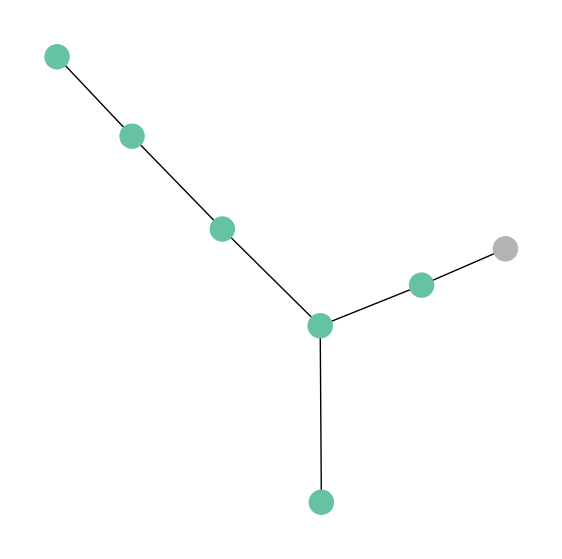

In [51]:
edges_data = [ data for (_, _, data) in graph_data['edges'] ]
edges_index = [ (n1, n2) for (n1, n2, _) in graph_data['edges'] ]

# check with node position and with added node color (add some tags when build connections)
edge_index = torch.tensor(edges_index, dtype=torch.long)
x = torch.tensor(graph_data['nodes'], dtype=torch.float)
edge_attr = torch.tensor(edges_data, dtype=torch.float)
y = torch.tensor(graph_data['targets'], dtype=torch.float)

data = Data(edge_index=edge_index.t().contiguous(), x=x, edge_attr=edge_attr, y=y)
print(data)

G = to_networkx(data, to_undirected=True)
colors = [ x.detach().numpy().argmax() for x in data.x]
visualize_graph(G, colors, None)